In [1]:
import numpy as np
import scipy.spatial as spa
import scipy 
import prody
from pathlib import Path
import importlib
from typing import Union

import rdkit

import dgl
import torch

%matplotlib widget
from matplotlib import pyplot as plt

# define hard-coded filepaths

In [4]:
DEV_INDEX_PATH = '/home/ian/projects/mol_diffusion/ligdiff/data/PDBbind_processed/train_index_mini.txt'
DEV_DATA_DIR = '/home/ian/projects/mol_diffusion/ligdiff/data/PDBbind/refined-set'

DEV_DATA_DIR = Path(DEV_DATA_DIR)

# import code for processing pdbbind

In [2]:
try:
    importlib.reload(process_pdbbind)
except NameError:
    import data_processing.pdbbind_processing as process_pdbbind

parse_protein = process_pdbbind.parse_protein
parse_ligand = process_pdbbind.parse_ligand
get_pocket_atoms = process_pdbbind.get_pocket_atoms

# define dataset class for PDB

In [14]:
class PDBbind(dgl.data.DGLDataset):

    def __init__(self, name: str, index_fpath: str, 
        raw_data_dir: str,
        processed_data_dir: str,
        pocket_cutoff: Union[int, float] = 6,
        receptor_k: int = 3):

        self.index_fpath: Path = Path(index_fpath)
        self.raw_data_dir: Path = Path(raw_data_dir)
        self.processed_data_dir: Path = Path(processed_data_dir)

        # hyperparameters for protein graph
        self.receptor_k: int = receptor_k
        self.pocket_cutoff: Union[int, float] = pocket_cutoff



        super().__init__(name=name) # this has to happen last because this will call self.process()

    def __getitem__(self, i):
        pass

    def __len__(self):
        return 1

    def process(self):

        # TODO: implement logic that only goes makes the graph objects if they don't already exist

        # get pdb ids from index file
        with open(self.index_fpath, 'r') as f:
            pdb_ids = [line.strip() for line in f]

        # we will want to do this paralellized over PDBs
        # but for now, a simple for loop will do
        for pdb_id in pdb_ids:

            # get all atoms from pdb file
            pdb_atoms: prody.AtomGroup = parse_protein(pdb_id)

            # get rdkit molecule from ligand, as well as atom types and charges
            ligand, lig_atom_positions, lig_atom_types, lig_atom_charges \
                 = parse_ligand(pdb_id)

            # get all protein atoms that form the binding pocket
            pocket_atom_positions, pocket_atom_types, pocket_atom_charges \
                 = get_pocket_atoms(pdb_atoms, lig_atom_positions, cutoff=6)
        


# method for finding binding pocket atoms

In [5]:
test_pdb_id = '1n4k'
protein_atoms = parse_protein(test_pdb_id, data_dir=DEV_DATA_DIR)
ligand, lig_atom_positions, lig_atom_types, lig_atom_charges = parse_ligand(test_pdb_id, data_dir=DEV_DATA_DIR)

BOX_PADDING = 15 # angstroms, padding around the bounding box where we will search for binding pocket atoms
POCKET_ATOM_CUTOFF = 4 # angstroms

# get bounding box of ligand
lower_corner = lig_atom_positions.min(axis=0, keepdim=True).values
upper_corner = lig_atom_positions.max(axis=0, keepdim=True).values

# get padded bounding box
lower_corner -= BOX_PADDING
upper_corner += BOX_PADDING

# get coordinates and atom types of all protein atoms 
# TODO: fix parse_protein so that it selects the *atoms we actually want* from the protein structure (waters? metals? etc.)... i.e., selectiion logic will be contained to parse_protein
protein_atom_positions = protein_atoms.getCoords()
protein_atom_elements = protein_atoms.getElements()
protein_atom_charges = protein_atoms.getCharges()

# convert protein atom positions to pytorch tensor
protein_atom_positions = torch.tensor(protein_atom_positions)

# find all protein atoms in padded bounding box
above_lower_corner = (protein_atom_positions >= lower_corner).all(axis=1)
below_upper_corner = (protein_atom_positions <= upper_corner).all(axis=1)
bounding_box_mask = above_lower_corner & below_upper_corner # boolean array with length equal to number of atoms in receptor structure, indicating whether each atom is in the "bounding box"

# get positions + features for bounding box atoms
box_atom_positions = protein_atom_positions[bounding_box_mask]
box_atom_elements = protein_atom_elements[bounding_box_mask]
box_atom_charges = protein_atom_charges[bounding_box_mask]

# find atoms that come within a threshold distance from a ligand atom
n_box_atoms = box_atom_positions.shape[0]
all_distances = spa.distance_matrix(box_atom_positions, lig_atom_positions)
# NOTE: even though the argumenets to distance_matrix were pytorch tensors, the returned array is a numpy array
min_dist_to_ligand = all_distances.min(axis=1) # distance from each box atom to closest ligand atom
pocket_atom_mask = min_dist_to_ligand < POCKET_ATOM_CUTOFF

# get positions + features for pocket atoms
pocket_atom_positions = box_atom_positions[pocket_atom_mask]
pocket_atom_elements = box_atom_elements[pocket_atom_mask]
pocket_atom_charges = box_atom_charges[pocket_atom_mask]

# get interface points
# TODO: apply clustering algorithm to summarize interface points
# for now, the interface points will just be the binding pocket points
# closest_ligand_index = all_distances.argmin(axis=1) # indicies of ligand atoms that are closest to each box atom


@> 4858 atoms and 1 coordinate set(s) were parsed in 0.02s.


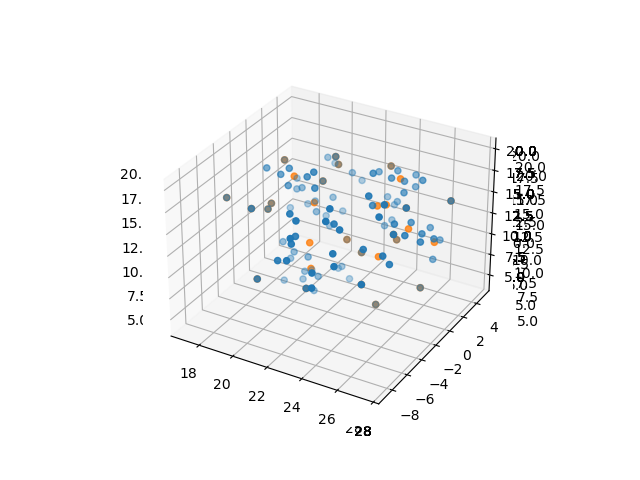

In [19]:
fig = plt.gcf()
ax = fig.add_subplot(projection='3d')

ax.scatter(pocket_atom_positions[:, 0], pocket_atom_positions[:, 1], pocket_atom_positions[:, 2])


cluster_assignments = scipy.cluster.hierarchy.fclusterdata(pocket_atom_positions, t=30, criterion='maxclust')

clustered_points = []
for cluster_idx in range(1, max(cluster_assignments)+1):
    cluster_mask = cluster_assignments == cluster_idx
    cluster_positions = pocket_atom_positions[cluster_mask]
    cluster_com = cluster_positions.mean(axis=0)

    # dist_to_com = np.linalg.norm(cluster_positions - cluster_com[None, :], axis=1)
    # avg_dist_to_com = dist_to_com.mean()
    # print(avg_dist_to_com)

    clustered_points.append(cluster_com)

clustered_points = np.stack(clustered_points, axis=0)

ax.scatter(clustered_points[:, 0], clustered_points[:, 1], clustered_points[:, 2], alpha=0.8)

plt.show()

In [18]:
max(cluster_assignments)

98

In [38]:
cluster_com

tensor([23.0120, -6.9730, 10.6190], dtype=torch.float64)

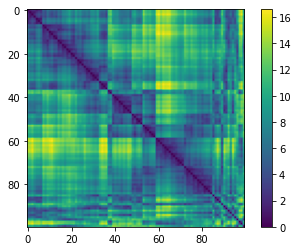

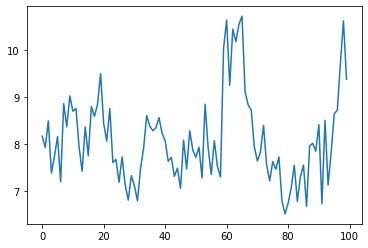

In [14]:
pocket_distances = spa.distance_matrix(pocket_atom_positions, pocket_atom_positions)
plt.imshow(pocket_distances)
plt.colorbar()
plt.show()

plt.plot(pocket_distances.mean(axis=1))

In [37]:
bounding_box_atoms.shape

torch.Size([1929, 3])

In [28]:
(protein_atom_positions > lower_corner).all(axis=1).shape

torch.Size([4858])

# build binding pocket graph

1. one-hot encode atom types
2. determine edges for KNN graph

In [17]:
def build_pocket_graph(atom_positions, atom_features, k=3, edge_algorithm='bruteforce'):
    # atom_positions is an array of shape (N, 3) where N is the number of atoms
    # atom_features is an array of shape (N, d) where N is the number of atoms and d is the size of the feature vector for each atom


    # construct KNN graph
    g = dgl.knn_graph(atom_positions, k=k, algorithm=edge_algorithm, dist='euclidean')
    return g

test_pdb_id = '1n4k'
protein_atoms = parse_protein(test_pdb_id, )
ligand, lig_atom_positions, lig_atom_types, lig_atom_charges = parse_ligand(test_pdb_id)
pocket_atom_positions, pocket_atom_types, pocket_atom_charges = get_pocket_atoms(protein_atoms, lig_atom_positions, cutoff=6)

g = build_pocket_graph(pocket_atom_positions, None)

TypeError: parse_protein() missing 1 required positional argument: 'data_dir'